<a href="https://colab.research.google.com/github/halilyaman/atlas-machine-learning/blob/master/CE475_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Methods**

1.   Multiple Linear Regression
2.   Polynomial Regression
3.   K-Nearest Neighbors
4.   Artificial Neural Networks

#**EDA**

**Import necessary libraries**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import xlwt
from xlwt import Workbook

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

**Load the data**

In [182]:
PATH = "drive/My Drive/IEU/CE475_project/data.csv"
data = pd.read_csv(PATH)

data.head()

,SampleNo,x1,x2,x3,x4,x5,x6,Y
0,1,32,-11,32,8,-11,24,10376.0
1,2,27,-20,10,55,-20,44,2143.0
2,3,27,-18,18,14,-18,47,4450.0
3,4,32,13,22,71,13,16,-28.0
4,5,17,-9,23,15,-9,44,5277.0


**Get training and test data**

In [0]:
training = data[:100]
test = data[100:]

training_inputs_df = training[["x1", "x2", "x3", "x4", "x5", "x6"]]
training_outputs_df = training["Y"]
test_inputs_df = test[["x1", "x2", "x3", "x4", "x5", "x6"]]

# **Data Distribution**

In [184]:
data = data.drop(["SampleNo"], axis=1)
data.describe()

,x1,x2,x3,x4,x5,x6,Y
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,100.000000
mean,18.716667,0.941667,17.066667,48.266667,0.941667,24.883333,1859.750000
std,12.470593,11.644089,10.810618,27.596959,11.644089,14.683887,2717.641332
min,0.000000,-20.000000,0.000000,2.000000,-20.000000,1.000000,-43.000000
25%,8.000000,-9.000000,7.000000,22.750000,-9.000000,12.000000,0.000000
50%,18.500000,1.000000,17.500000,48.000000,1.000000,24.000000,753.500000
75%,29.000000,11.000000,26.500000,74.000000,11.000000,37.250000,2262.500000
max,40.000000,20.000000,35.000000,97.000000,20.000000,50.000000,12575.000000


**Plot the histogram of training output**

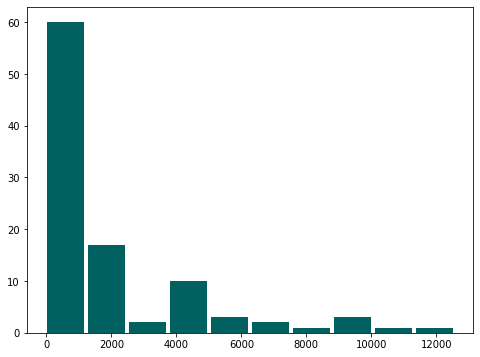

In [185]:
Y_train_hist = training_outputs_df.hist(
    figsize=(8, 6),
    grid=False,
    color='#016161',
    rwidth=0.9
)

**Plot the histogram of training input attributes**

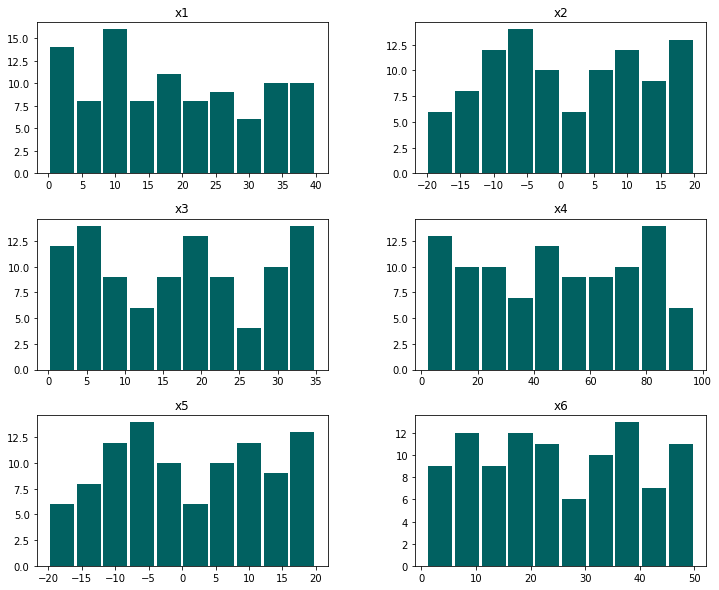

In [186]:
X_train_hist = training_inputs_df.hist(
    figsize=(12, 10),
    grid=False,
    color='#016161', 
    rwidth=0.9)

**Plot the histogram of test input attributes**

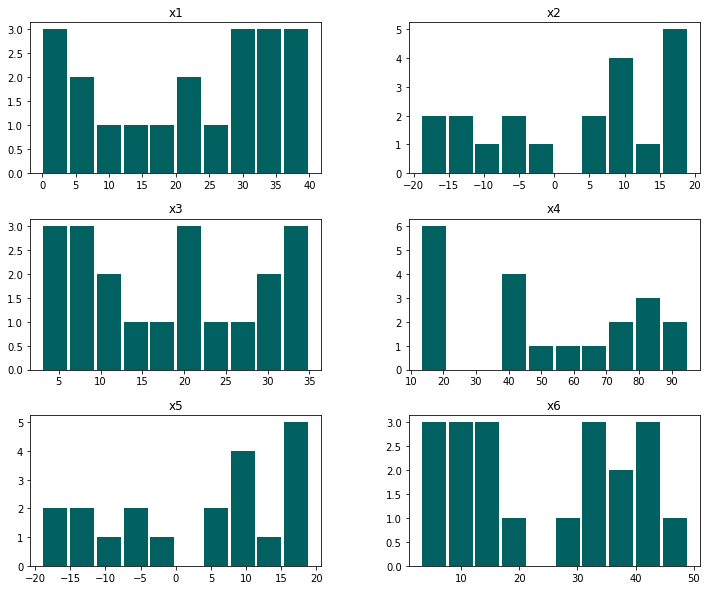

In [187]:
X_test_hist = test_inputs_df.hist(
    figsize=(12, 10),
    grid=False,
    color='#016161',
    rwidth=0.9)

**Plot the correlation matrix of training input variables**

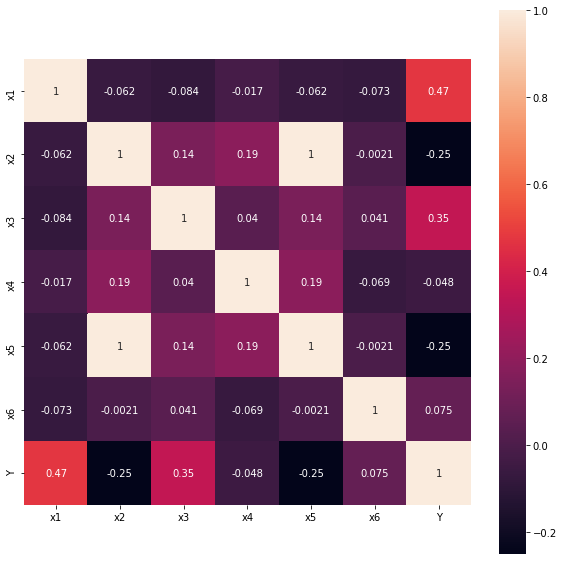

In [188]:
C_mat = data.corr()
fig = plt.figure(figsize=(10, 10))
sb.heatmap(C_mat, vmax=1.0, square=True, annot=True)

**Plot pairwise relationships in a dataset**

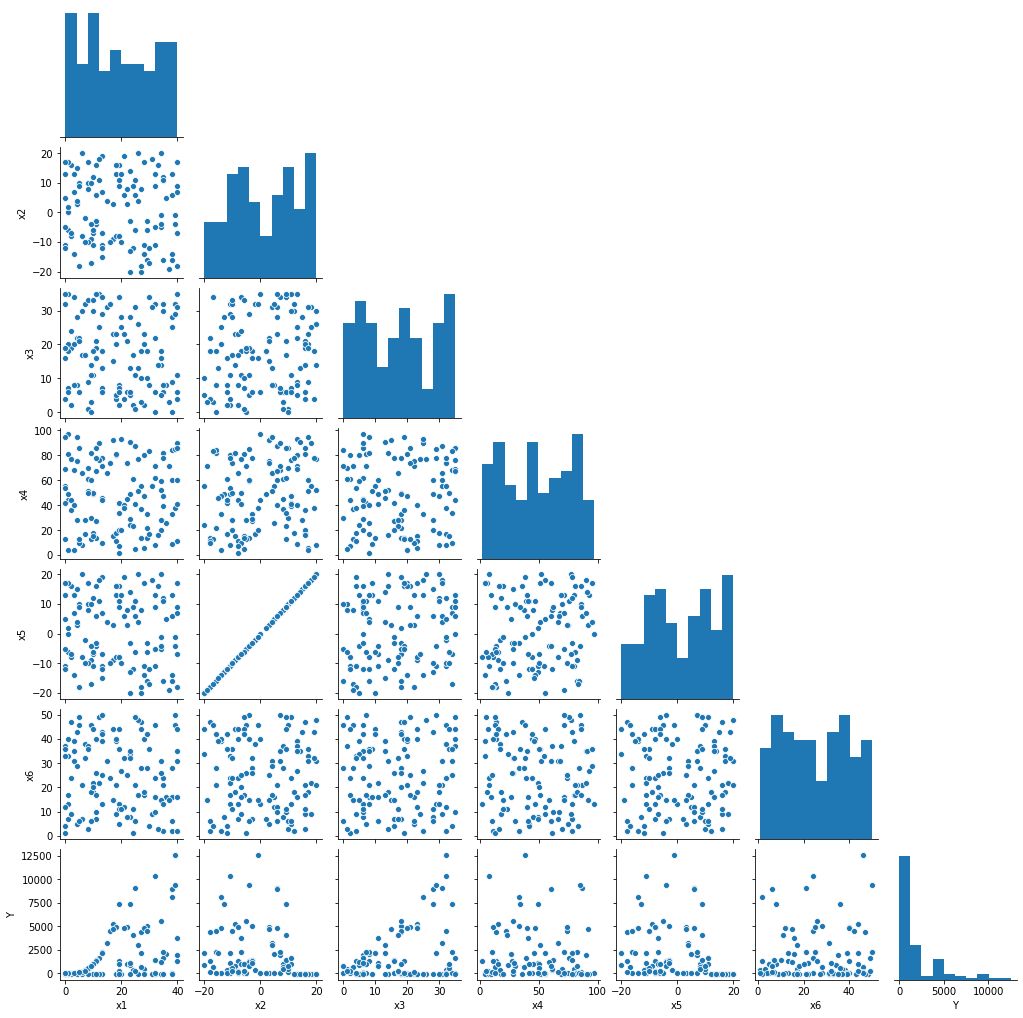

In [189]:
sb.pairplot(data, height=2, corner=True)

# **Interpretation of the Distribution**

**If we analyze the distributions, we see that x2 and x5 are exactly the same. So we can drop one of them.**

In [190]:
# drop the column "x5"
training_inputs_df = training_inputs_df.drop(["x5"], axis=1)
test_inputs_df = test_inputs_df.drop(["x5"], axis=1)

# convert data frames to numpy array
training_inputs = np.array(training_inputs_df)
training_outputs = np.array(training_outputs_df)
test_inputs = np.array(test_inputs_df)

# print the sizes
print("Training data size: {}".format(training_inputs.shape[0]))
print("Test data size: {}".format(test_inputs.shape[0]))

Training data size: 100
Test data size: 20


# **Helper Functions**

In [0]:
def get_r_square(y_pred, y):

  y_avg = np.mean(y)
  rss = np.sum(np.square(y - y_pred))
  tss = np.sum(np.square(y - y_avg))

  return 1 - (rss / tss)

In [0]:
def get_adj_rsquare(y_pred, y, p, n):

  return 1 - (1 - get_r_square(y_pred, y)) * ((n - 1)/(n - p - 1))

In [0]:
def plot_result(pred_val, actual_val):

  """Plots the predictions vs actual output values."""

  pred_val = pred_val.flatten()
  actual_val = actual_val.flatten()

  plt.scatter(pred_val, actual_val)
  plt.xlabel("Predicted Values", fontsize=14)
  plt.ylabel("Actual Values", fontsize=14)
  plt.show()

  plot = sb.jointplot(pred_val, actual_val, kind="reg", color="blueviolet")
  plot.set_axis_labels("Predicted Values", "Actual Values", fontsize=14)

  plt.show()

In [0]:
def get_statistics(y_pred, y, n_coefs=None):

  """Calculate some useful statistics for evaluating the models."""

  stats = dict()

  y_mean = np.mean(y)

  rss = np.sum(np.square(y - y_pred))
  tss = np.sum(np.square(y - y_mean))

  stats["rss"] = rss
  stats["tss"] = tss
  stats["r_square"] = 1 - (rss / tss)
  stats["mse"] = np.sum(np.square(y_pred - y))
  
  if n_coefs != None:
    
    stats["f_statistic"] = ((tss - rss) / n_coefs) / (rss / (len(y) - n_coefs - 1))
    stats["adjusted_r_square"] = 1 - ((rss / (len(y) - n_coefs - 1)) / (tss / (len(y) - 1)))

  return stats

In [0]:
def normalize_data(X, y):

  """Data normalization might improve the model accuracy"""

  scaler_X = MinMaxScaler()
  scaler_Y = MinMaxScaler()

  y = np.reshape(y, (-1, 1))

  scaler_X.fit(X)
  scaler_Y.fit(y)

  xscale = scaler_X.transform(X)
  yscale = scaler_Y.transform(y)

  return xscale, yscale, scaler_X, scaler_Y

In [0]:
def denormalize_data(data, scaler):

  """Inverse of the data normalization"""

  data = scaler.inverse_transform(data).T

  return data

In [0]:
def write_to_excel(data):

  wb = Workbook()

  sheet = wb.add_sheet("Prediction")

  for i, v in enumerate(data):
    
    sheet.write(i, 0, str(v))

  wb.save("submission.xls")

#**Recursive Feature Elimination Method With Linear Model**

In [198]:
# logging the R^2 values for number of attributes
log = dict()
adj_rsquared_values = []
linear_model = LinearRegression()

X = training_inputs
y = training_outputs

# iterate on attributes
for i in reversed(range(len(X.T))):
  
  kf = KFold(n_splits=4, random_state=None, shuffle=False)
  adj_rsquared_samples = []

  for train_index, test_index in kf.split(X):
    
    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rfe = RFE(linear_model, i+1)
    fit = rfe.fit(X_train, y_train)

    columns = []

    # Calculate the R^2 value
    adj_r_square = get_adj_rsquare(fit.predict(X_test), y_test, i+1, len(y_train))
    adj_rsquared_samples.append(adj_r_square)
  
  
  adj_rsquared_values.append(np.mean(adj_rsquared_samples))


  # save the selected columns
  for j, val in enumerate(fit.support_): 
    if val:
      columns.append(training_inputs_df.columns[j])
  
  
  log[i] = dict()
  log[i]["n_feature"] = i
  log[i]["selected_features"] = columns
  log[i]["adj_rsquared"] = np.mean(adj_rsquared_samples)

  print(f"Selected Features: {columns}")
  print(f"Adjusted R^2: {np.mean(adj_rsquared_samples)}")
  print("----------------------------------------------------------------")


best_adj_rsquared = np.max(adj_rsquared_values)

for i in range(len(log)):
  if log[i]["adj_rsquared"] == best_adj_rsquared:
    print("Best Score Features: "+str(log[i]["selected_features"]))
    print("Best Adjusted R^2: "+str(log[i]["adj_rsquared"]))
    

Selected Features: ['x1', 'x2', 'x3', 'x4', 'x6']
Adjusted R^2: 0.29703493542515635
----------------------------------------------------------------
Selected Features: ['x1', 'x2', 'x3', 'x4']
Adjusted R^2: 0.3282151046348831
----------------------------------------------------------------
Selected Features: ['x1', 'x2', 'x3']
Adjusted R^2: 0.3532079259779422
----------------------------------------------------------------
Selected Features: ['x1', 'x3']
Adjusted R^2: 0.2952015961329941
----------------------------------------------------------------
Selected Features: ['x1']
Adjusted R^2: 0.10095155450619864
----------------------------------------------------------------
Best Score Features: ['x1', 'x2', 'x3']
Best Adjusted R^2: 0.3532079259779422


# **L1 Regularization**

**This is another technique used for eliminating unimportant features**

In [0]:
def l1_regularization(X, y, alpha=2, n_splits=4):

  """
  This function is used for evaluating the lasso model.

  Parameters:
  X: input data
  y: output data
  alpha: constant that multiplies the L1 term
  alpha = 0 is equivalent to an ordinary least square
  n_splits: number of folds, used for cross validation

  Returns:
  r_square: R^2 value for evaluating the model performance
  predictions: predicted results
  """

  lasso = Lasso(alpha=alpha, normalize=True)
  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  adj_rsquares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit the training data to the model
    lasso.fit(X_train, y_train)

    # calculate R^2 value
    adj_rsquare = get_adj_rsquare(lasso.predict(X_test), y_test, 5, len(y_test))
    adj_rsquares.append(adj_rsquare)

    # get the prediction results
    predictions = np.append(predictions, lasso.predict(X_test))

  # calculate mean of r square values
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions, lasso.coef_

**Try the alpha values in range 1 to 30, and decide the best one based on R^2 value**

In [200]:
# find best alpha value for lasso
max_adj_rsquare = 0
best_alpha = 1

for i in range(1, 30):

  adj_rsquare, lasso_preds, _ = l1_regularization(training_inputs, training_outputs, alpha=i, n_splits=4)

  print("Alpha: {}   R^2: {}".format(i, adj_rsquare))

  if adj_rsquare > max_adj_rsquare:
    
    max_adj_rsquare = adj_rsquare
    best_alpha = i

Alpha: 1   R^2: 0.1744691655990636
Alpha: 2   R^2: 0.1770399554961985
Alpha: 3   R^2: 0.17952213070911988
Alpha: 4   R^2: 0.1818508606022458
Alpha: 5   R^2: 0.18402613796437237
Alpha: 6   R^2: 0.18580837451285573
Alpha: 7   R^2: 0.18738960477757435
Alpha: 8   R^2: 0.18883298383592567
Alpha: 9   R^2: 0.19013852344754262
Alpha: 10   R^2: 0.19119442042014154
Alpha: 11   R^2: 0.192095756713539
Alpha: 12   R^2: 0.19288178003350256
Alpha: 13   R^2: 0.19355249038003144
Alpha: 14   R^2: 0.19410788775312646
Alpha: 15   R^2: 0.1945479721527873
Alpha: 16   R^2: 0.19487274357901416
Alpha: 17   R^2: 0.19511797826191632
Alpha: 18   R^2: 0.19525466317237752
Alpha: 19   R^2: 0.1952800598450828
Alpha: 20   R^2: 0.19480352653523272
Alpha: 21   R^2: 0.19403142442467852
Alpha: 22   R^2: 0.19315547180454892
Alpha: 23   R^2: 0.19217566867484356
Alpha: 24   R^2: 0.19109201503556275
Alpha: 25   R^2: 0.18990451088670632
Alpha: 26   R^2: 0.18861315622827435
Alpha: 27   R^2: 0.1872179510602669
Alpha: 28   R^2: 0

In [201]:
# apply lasso with the best alpha value
adj_rsquare, lasso_preds, lasso_coef = l1_regularization(training_inputs, training_outputs, alpha=best_alpha, n_splits=4)

print("Alpha value: {}\nAdjusted R^2: {}".format(best_alpha, adj_rsquare))
print("Coefficients: {}".format(lasso_coef))

Alpha value: 19
Adjusted R^2: 0.1952800598450828
Coefficients: [107.22088359 -63.39467195 106.35340346  -0.           0.        ]


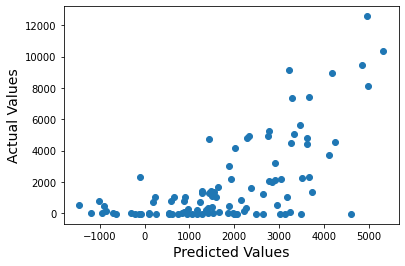

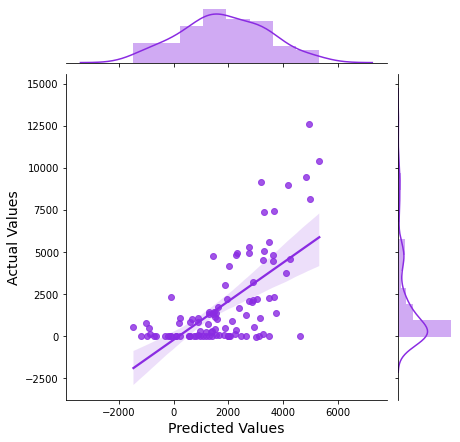

In [202]:
plot_result(lasso_preds, training_outputs)

**Remove the attributes x4 and x6**

In [0]:
training_inputs = training_inputs[:, 0:3]
test_inputs = test_inputs[:, 0:3]

# **1. Multiple Linear Regression**

In [0]:
def multi_lin_reg(X, y, n_splits=10):

  """
  This function is used for evaluating a multiple linear regression model.

  Parameters:
  X: input data
  y: output data
  n_splits: number of folds, used for cross validation

  Returns:
  r_square: R^2 value for evaluating the model performance
  predictions: predicted results
  """

  linear_model = LinearRegression()
  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
  
  adj_rsquares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):
    
    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit the training data to the model
    linear_model.fit(X_train, y_train)

    # calculate adjusted R^2 value
    adj_rsquare = get_adj_rsquare(
        linear_model.predict(X_test),
        y_test,
        p=3, n=100)
    adj_rsquares.append(adj_rsquare)

    # get the prediction results
    predictions = np.append(predictions, linear_model.predict(X_test))

  # calculate mean of r square values of each fold
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions

In [225]:
# apply multiple linear regression and get the R^2 value
adj_rsquare, MLR_preds = multi_lin_reg(training_inputs, training_outputs, n_splits=4)

print("Cross Validation R^2 adjusted: {}".format(adj_rsquare))

Cross Validation R^2 adjusted: 0.3600363895972628


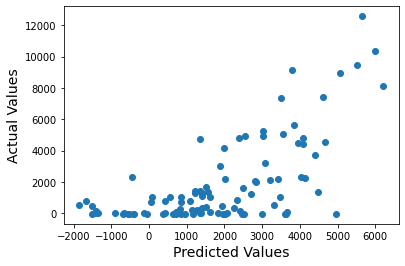

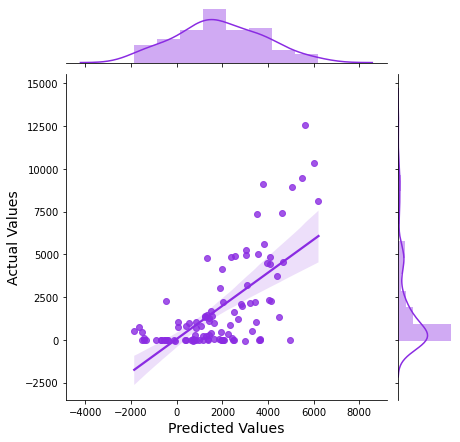

In [226]:
# plot the results
plot_result(MLR_preds, training_outputs)

# **2. Polynomial Regression**
**Since the data doesn't fit well enough the linear model, polynomial model might be a better approach.**

In [0]:
def poly_reg(X, y, degree=2, n_splits=5):

  """
  This function is used for evaluating the polynomial model.

  Parameters:
  X: input data
  y: output data
  degree: degree of the polynomial features
  n_splits: number of folds, used for cross validation

  Returns:
  r_square: R^2 value for evaluating the model performance
  predictions: predicted results
  """
  
  poly_features = PolynomialFeatures(degree=degree)

  X = poly_features.fit_transform(X)
  polynomial_model = LinearRegression()

  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  adj_rsquares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  
    polynomial_model.fit(X_train, y_train)

    # calculate adjusted R^2 value
    adj_rsquare = get_adj_rsquare(
        polynomial_model.predict(X_test),
        y_test,
        p=3, n=100)
    adj_rsquares.append(adj_rsquare)

    # get the predictions
    predictions = np.append(predictions, polynomial_model.predict(X_test))

  # calculate mean of r square values
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions


In [230]:
adj_rsquare, poly_preds = poly_reg(training_inputs, training_outputs, degree=2, n_splits=4)

print("Cross validation R^2 adjusted: {}".format(adj_rsquare))

Cross validation R^2 adjusted: 0.6356181902951482


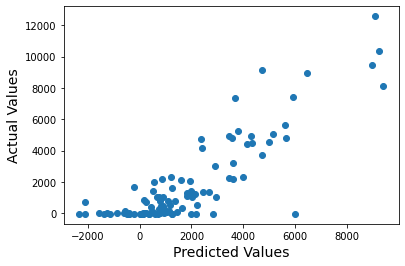

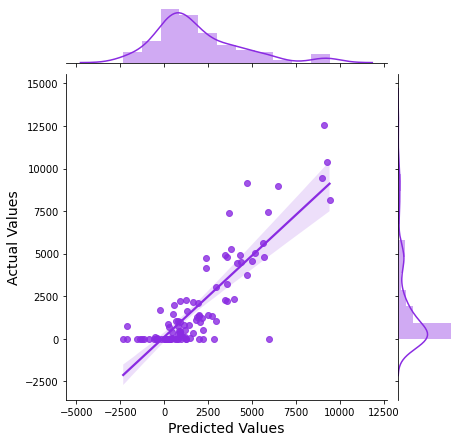

In [231]:
plot_result(poly_preds, training_outputs)

# **3. K-Nearest Neighbors**

In [0]:
def knn(X, y, algorithm="auto", n_neighbors=5, n_splits=5):

  """
  This function is used for evaluating the knn model.

  Parameters:
  X: input data
  y: output data
  algorithm: algorithm used to compute the nearest neighbors
  n_neighbors: number of neighbors
  n_splits: number of folds, used for cross validation

  Returns:
  r_square: R^2 value for evaluating the model performance
  predictions: predicted results
  """
  
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, algorithm=algorithm)

  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  adj_rsquares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  
    knn.fit(X_train, y_train)

    # calculate R^2 value
    adj_rsquare = get_adj_rsquare(
        knn.predict(X_test),
        y_test,
        p=3, n=100)
    adj_rsquares.append(adj_rsquare)

    # get the predictions
    predictions = np.append(predictions, knn.predict(X_test))

  # calculate mean of r square values
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions

**Try the number of neighbors in range 1 to 20, and decide the best one based on R^2 value.**

In [235]:
best_n_neighbors = 0
best_adj_rsquare = 0

xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

for i in range(1, 20):

  adj_rsquare, knn_preds = knn(
      xscale, 
      yscale, 
      algorithm="brute", 
      n_neighbors=i,
      n_splits=4)

  if adj_rsquare > best_adj_rsquare:

    best_adj_rsquare = adj_rsquare
    best_n_neighbors = i
  
  print("{}- Adjusted R^2: {}".format(i, adj_rsquare))

1- Adjusted R^2: 0.6954365759618797
2- Adjusted R^2: 0.7501714887533386
3- Adjusted R^2: 0.7155039676455481
4- Adjusted R^2: 0.7116688248096674
5- Adjusted R^2: 0.7013552748655008
6- Adjusted R^2: 0.6343578554400935
7- Adjusted R^2: 0.5990923153503608
8- Adjusted R^2: 0.5389674113619214
9- Adjusted R^2: 0.546816660144833
10- Adjusted R^2: 0.5267064173293341
11- Adjusted R^2: 0.5175649257277612
12- Adjusted R^2: 0.5197887272396207
13- Adjusted R^2: 0.49554721624729026
14- Adjusted R^2: 0.46225329472368076
15- Adjusted R^2: 0.43641158884258835
16- Adjusted R^2: 0.4370173797849286
17- Adjusted R^2: 0.42116230793743953
18- Adjusted R^2: 0.40214830935020285
19- Adjusted R^2: 0.3774341129827763


In [236]:
adj_rsquare, knn_preds = knn(
      xscale, 
      yscale,
      algorithm="brute", 
      n_neighbors=best_n_neighbors,
      n_splits=4)

print("Number of neighbors: {}\nR^2: {}".format(best_n_neighbors, adj_rsquare))

Number of neighbors: 2
R^2: 0.7501714887533386


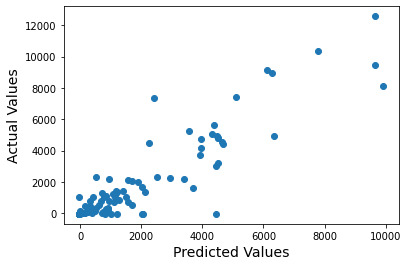

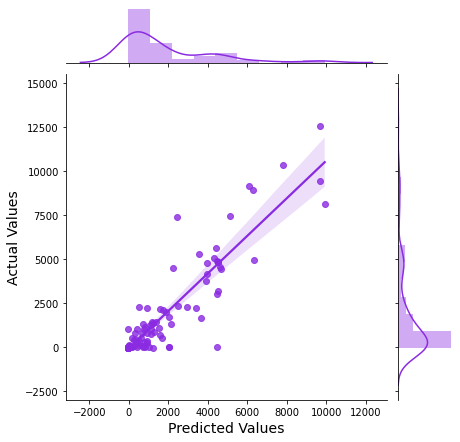

In [237]:
knn_preds = np.reshape(knn_preds, (-1, 1))
knn_preds = denormalize_data(knn_preds, scaler_Y)

plot_result(knn_preds, training_outputs)

# **4. Artificial Neural Networks**

In [0]:
def build_model(input_dim):

  """
  Neural network model and layers are created in this function.

  Returns:
  NN_model: neural network model that we built
  """

  NN_model = tf.keras.Sequential()

  NN_model.add(tf.keras.layers.Dense(50, input_dim=input_dim, kernel_initializer="normal", activation="relu"))
  NN_model.add(tf.keras.layers.Dense(40, kernel_initializer="normal", activation="relu"))
  NN_model.add(tf.keras.layers.Dense(1, kernel_initializer="normal", activation="linear"))

  NN_model.compile(
      optimizer=tf.keras.optimizers.Adam(), 
      loss="mse",
      metrics=["mse", "mae"]
  )

  return NN_model

In [0]:
# get the model
NN_model = build_model(3)

# normalize the training data
xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

# fitting data to the model
history = NN_model.fit(
        xscale,
        yscale,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        verbose=0,
    )

**Loss values for both training and validation data**

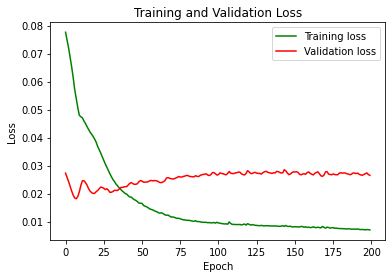

In [216]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(loss))

plt.plot(epochs, loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

In [217]:
NN_preds = NN_model.predict(xscale)
NN_preds = scaler_Y.inverse_transform(NN_preds).T

r_square = get_statistics(NN_preds, training_outputs)["r_square"]
print("R^2: {}".format(r_square))

R^2: 0.7624202616619953


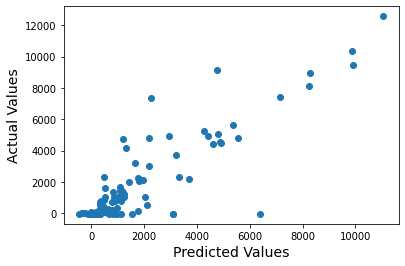

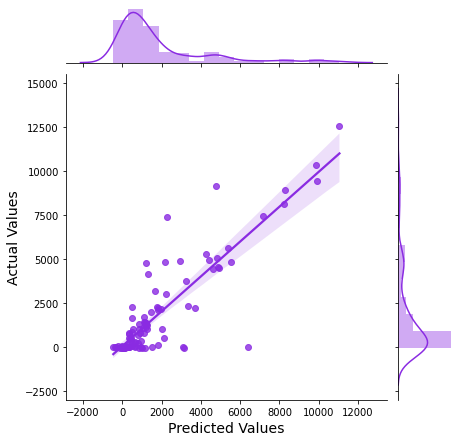

In [218]:
plot_result(NN_preds, training_outputs)

# **Plot The Results Of All Techniques Used**

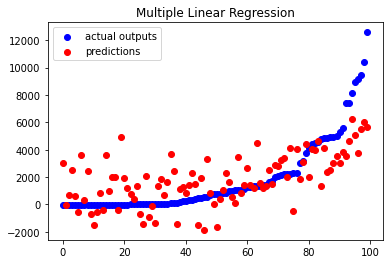

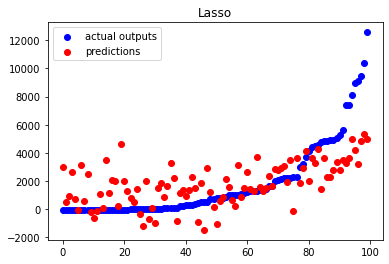

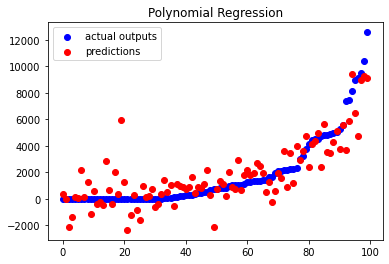

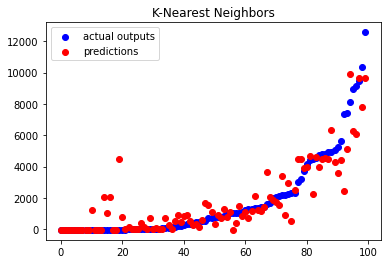

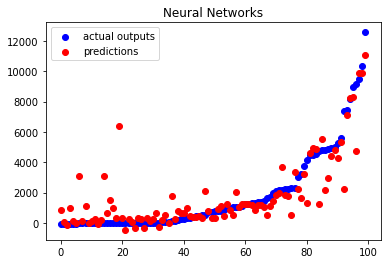

In [238]:
y = np.reshape(training_outputs, (-1, 1))

y_hat = np.reshape(MLR_preds, (-1, 1))

outputs = np.vstack([training_outputs, MLR_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Multiple Linear Regression")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(lasso_preds, (-1, 1))

outputs = np.vstack([training_outputs, lasso_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Lasso")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(poly_preds, (-1, 1))

outputs = np.vstack([training_outputs, poly_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Polynomial Regression")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(knn_preds, (-1, 1))

outputs = np.vstack([training_outputs, knn_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("K-Nearest Neighbors")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(NN_preds, (-1, 1))

outputs = np.vstack([training_outputs, NN_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Neural Networks")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

# **Submission**

**Based on R^2 values, I decided to use neural network architecture to submit my project.**

These predictions can be a little bit different from submitted predictions because I tried many times.
[[6308]
 [ 990]
 [4638]
 [2300]
 [ 288]
 [ 149]
 [ 791]
 [6287]
 [9518]
 [6026]
 [ 376]
 [1304]
 [1632]
 [ 582]
 [ 478]
 [9885]
 [ -29]
 [ 181]
 [ 168]
 [ 229]]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2c7fda79b0>]],
      dtype=object)

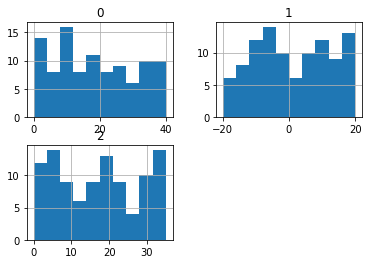

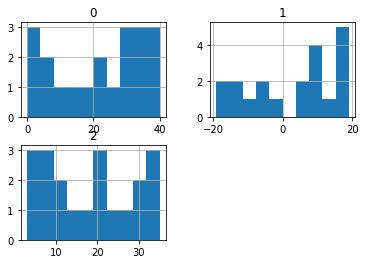

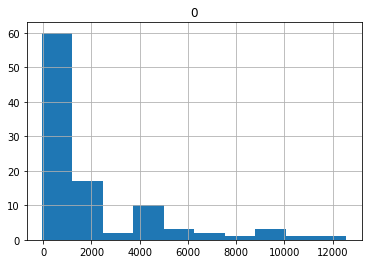

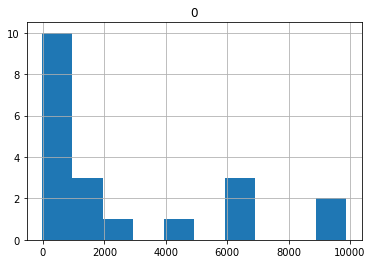

In [220]:
# normalize the test data
test_scaled = scaler_X.transform(test_inputs)

# get the predictions
preds = NN_model.predict(test_scaled)

# denormalize and print the predictions
submission = denormalize_data(preds, scaler_Y).T.astype("int")
print("These predictions can be a little bit different from submitted"
      " predictions because I tried many times.")
print(submission)

pd.DataFrame(training_inputs).hist()
pd.DataFrame(test_inputs).hist()
pd.DataFrame(training_outputs).hist()
pd.DataFrame(submission).hist()

In [0]:
# save the test predictions to an excel file
write_to_excel(submission.T[0])